# Lab 8: Neural Networks for Biological Sequence Data

In this recitation, we will learn to train some neural networks on DNA sequences. Specifically, we will build CNN/RNN based neural networks to predict transcription factor binding sites. This notebook is adapted from https://github.com/const-ae/Neural_Network_DNA_Demo

In [48]:
__author__ = "Ren Yi"
__version__ = "BMSC-GA 4493/BMIN-GA 3007, NYU, Spring 2019"

## Some biological background
Transcription is the first step of gene expression, in which a particular segment of DNA is copied into RNA (especially mRNA) by the enzyme RNA polymerase. Transcription initiation is heavily regulated by multiple layers of cellular machinery in order to maintain normal body functions. Transcription factors (TFs) are the major group of proteins that regulates transcription initiation. TF regulates transcription initiation by binding to particular DNA sequences (termed TF binding sites, or TFBS), and activating or repressing the target gene expression. Therefore, TF binding to DNA is sequence specific and their sequence preferences are usually represented by sequence motifs.

## Problem setup

In [1]:
import numpy as np
from helper import IOHelper, SequenceHelper
import motif_plotter
import random
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

# from sklearn.metrics import roc_curve, auc, average_precision_score
# random.seed(1234)

### Load sequence data
Let's look at transcription factor [pu1](https://en.wikipedia.org/wiki/SPI1) and load file `data/pu1.fa.gz`. In this file, each entry contains a 100 base pair (bp) DNA sequence bound by this TF (positive samples).

In [ ]:
!gunzip -c data/pu1.fa.gz | head

In [2]:
input_fasta_data = IOHelper.get_fastas_from_file("data/pu1.fa.gz", uppercase=True)
sequence_length = len(input_fasta_data.sequence[0])
seq_matrix = SequenceHelper.do_one_hot_encoding(input_fasta_data.sequence, sequence_length,
                                                SequenceHelper.parse_alpha_to_seq)

Let's generate The negative samples by shuffling the positive samples

In [3]:
# Helper Function that creates the negative set of examples
# by shuffling the positive examles
def do_dinucleotide_shuffling(X, size=1):
    x_shuffled = np.repeat(X, size, 0)

    for x in range(0, x_shuffled.shape[0]):
        random_index = np.arange(0, int(X.shape[1]/2))
        np.random.shuffle(random_index)
        for y in range(0, int(X.shape[1]/2)):
            x_shuffled[x,y*2, ] = X[int(x%X.shape[0]),random_index[y]*2]
            x_shuffled[x,(y*2)+1, ] = X[int(x%X.shape[0]),(random_index[y]*2)+1]

    return x_shuffled


seq_shuffled = do_dinucleotide_shuffling(np.array([[[e] for e in list(x)] for x in input_fasta_data.sequence]), size=1)
seq_shuffled = np.array(["".join(seq_shuffled[x, :, 0]) for x in range(seq_shuffled.shape[0])])
seq_shuffled_matrix = SequenceHelper.do_one_hot_encoding(seq_shuffled, sequence_length,
                                                         SequenceHelper.parse_alpha_to_seq)

In [ ]:
seq_shuffled_matrix.shape

### Generate training and testing data

In [5]:
seed = 1234
sequences = np.concatenate((seq_matrix, seq_shuffled_matrix))
sequences = np.nan_to_num(sequences)
labels = np.concatenate((np.ones(seq_matrix.shape[0]), np.zeros(seq_shuffled_matrix.shape[0])))

X_train, X_test = train_test_split(sequences, test_size=0.1, random_state=seed)
y_train, y_test = train_test_split(labels, test_size=0.1, random_state=seed)

## Model time!

In this section, I would like you to use the knowledge you learned from lab6 and lab7 to build a model (implement training and testing loop, construct DataLoader, and define the model architecture) to predict TF binding that is able to achieve 0.9 AUC on validation set. You're free to choose any model architectures we've covered in this course.

### DataLoader

### Training and validation loop

### Model architecture

## Understanding Predictions

Your results so far should allow you to conclude that the neural network is quite effective in learning to distinguish sequences that bind the protein from sequences that do not. But how does the neural network classifier manage to do so? To answer this question, we compute a simple [__saliency map__](https://en.wikipedia.org/wiki/Saliency_map). Saliency map calculates the gradient of the model's prediction with respect to each individual nucleotide, therefore tells you how important each nucleotide is for making model prediction. Gradients of a given input sequence desides how much a small change to that nucleotide will change the output value. Therefore, visualizing these gradients for a given input sequence should provide some clues about what nucleotides form the binding motifs that we are trying to identify.

Transcription factor Pu1 has shown to have preference for purine-rich (AG-rich) sequences [[1]](http://v1.factorbook.org/mediawiki/index.php/PU.1). If implemented correctly, the resulting saliency maps would show  that AG-rich regions are important for predictions.

In [34]:
def compute_saliency_maps(X, y, model):
    # Make sure the model is in "test" mode
    model.eval()
    # X needs gradient
    X.requires_grad_()

    #forward pass
    scores = model(X)
#     import ipdb; ipdb.set_trace()
    scores = (scores.gather(1, y.view(-1, 1)).squeeze())
    
    #backward pass
    scores.backward(torch.ones(scores.shape))
#     scores.backward(torch.FloatTensor([1.0]*scores.shape[0]))
    
    #saliency
    saliency, _ = torch.max(X.grad.data.abs(), dim=2)
#     saliency = X.grad.data.abs()
    
    return saliency

def retrieve_samples(sequences, labels, sample_class=1, num_samples=5, seed=1234):
    indices = np.where(labels == sample_class)[0]
    np.random.seed(seed)
    indices = np.random.choice(indices, num_samples, replace=False)
    
    X = torch.FloatTensor(sequences[indices])
    y = torch.LongTensor(labels[indices])
    
    return X, y

def plot_saliency_maps(X, saliency):
    num_samples = X.shape[0]
    for idx in range(num_samples):
        fig=plt.figure(figsize=(10, 2))
        ax=fig.add_subplot(111)
        motif_plotter.make_single_sequence_spectrum(ax, X[idx].reshape((100, 4)),
                                                    saliency[idx].reshape(100,1))
        plt.show()

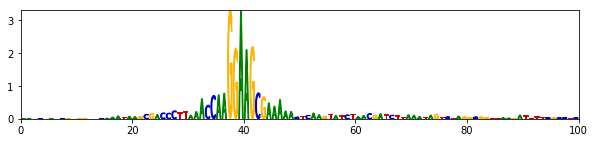

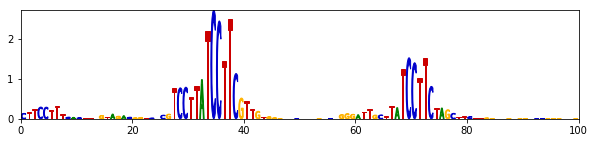

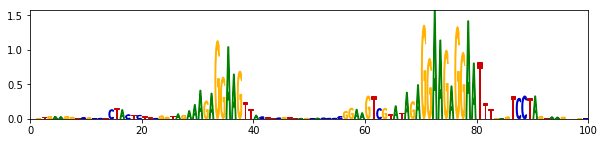

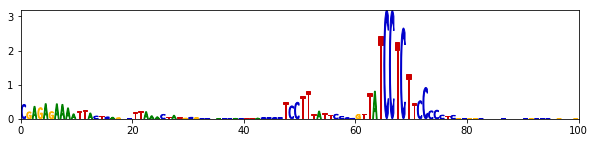

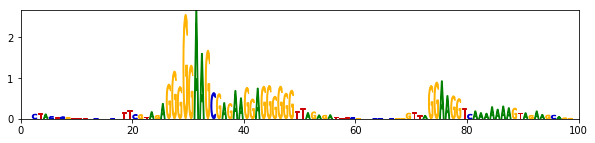

In [46]:
# Let's find some positive samples and calculate their saliency maps
X, y = retrieve_samples(X_train, y_train, num_samples=5)
sal = compute_saliency_maps(X, y, model)
# import ipdb; ipdb.set_trace()
plot_saliency_maps(X.detach().numpy(), sal.numpy())